In [1]:
import numpy as onp
orig_im = onp.load('../test-data/elliptical_ring.npy')

import numpy as onp
import jax.numpy as jnp
import jax.scipy as jsp
import jax
from jaxri import lnprob, priors
from matplotlib import pyplot as plt

from jax.experimental import optimizers
from scipy import ndimage

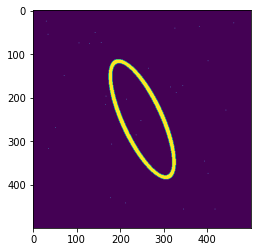

In [2]:
plt.imshow(orig_im)

In [3]:
from PIL import Image
im = Image.fromarray(orig_im).convert("L")

In [4]:
im2 = im.resize((50, 50))

In [5]:
ground_truth = onp.array(im2, dtype=onp.float) * 5

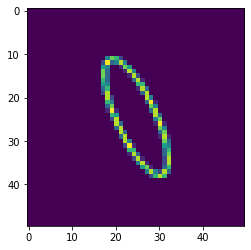

In [6]:
plt.imshow(ground_truth)

In [7]:
ground_truth.max()

45.0

In [31]:
conv = ndimage.gaussian_filter(ground_truth, 10./2.3)

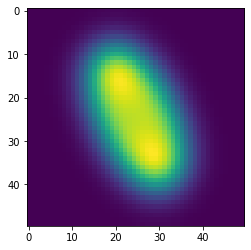

In [32]:
plt.imshow(conv)

In [13]:
uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=',')) * 50
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))
uv_arr = jax.device_put(uv_arr)
lm_arr = jax.device_put(lm_arr)
vis_obs = jax.device_put(vis_obs)
def prior(im):
    return jsp.stats.norm.logpdf(im, loc=0, scale=4)
def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)
def loss(im):
    return - (jnp.sum(prior(im)) + lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, sigma=1))

In [14]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(50, 50)) * 1
init_fun, update_fun, get_params = optimizers.adam(1e-3)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(loss)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

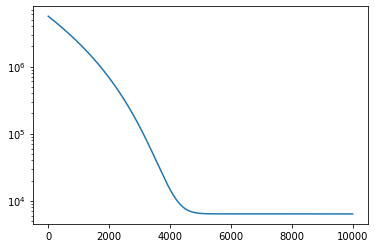

In [15]:
plt.plot(loss_list)
plt.yscale('log')

In [17]:
loss_list = []
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

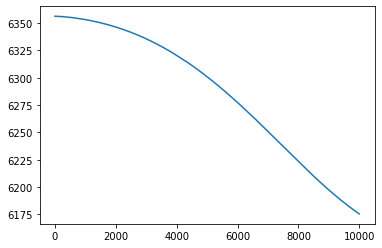

In [18]:
plt.plot(loss_list)

In [20]:
loss_list = []
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

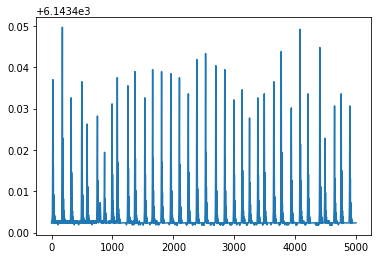

In [23]:
plt.plot(loss_list[-5000:])

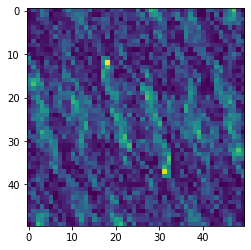

In [22]:
plt.imshow(jnp.abs(get_params(opt_state))/jnp.abs(get_params(opt_state)).max())

In [24]:
ans = jnp.abs(get_params(opt_state))

In [25]:
conv_ans = ndimage.gaussian_filter(onp.asarray(ans), 4./2.3)

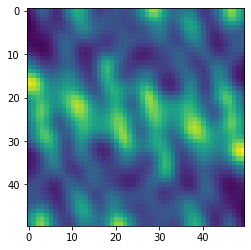

In [26]:
plt.imshow(conv_ans)

## Try generating a prior from a simulated prior observation (lower res, has noise)

In [36]:
prior_obs = conv + 0.5 * onp.random.randn(*conv.shape)

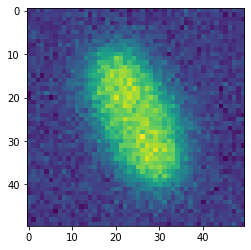

In [37]:
plt.imshow(prior_obs)

In [39]:
mean_map = ndimage.uniform_filter(prior_obs, (10, 10))
sqr_mean_map = ndimage.uniform_filter(prior_obs**2, (10, 10))
std_map = onp.sqrt(sqr_mean_map - mean_map**2)

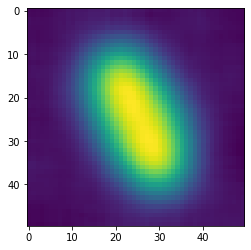

In [40]:
plt.imshow(mean_map)

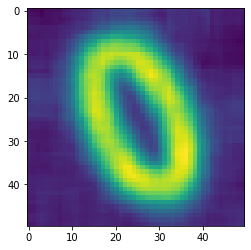

In [41]:
plt.imshow(std_map)

In [42]:
def prior(im):
    return jsp.stats.norm.logpdf(im, loc=mean_map, scale=std_map)
def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)
def loss(im):
    return - (jnp.sum(prior(im)) + lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, sigma=1))

In [44]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(50, 50)) * 1
init_fun, update_fun, get_params = optimizers.adam(1e-3)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(loss)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

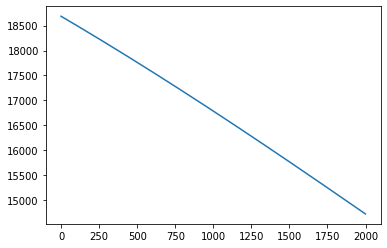

In [46]:
plt.plot(loss_list[-2000:])

In [48]:
loss_list = []
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

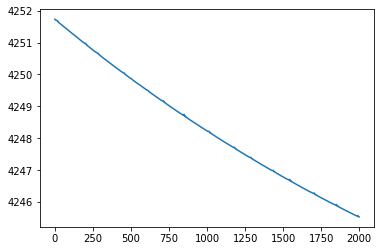

In [49]:
plt.plot(loss_list[-2000:])

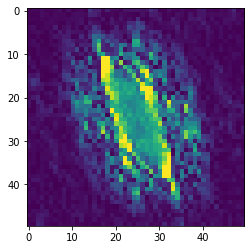

In [60]:
plt.imshow(jnp.abs(get_params(opt_state)), vmin=0, vmax=10)

In [61]:
def compute_i(uv: jnp.array, lm: jnp.array, vis: jnp.array):
    l, m = lm
    u, v = uv
    return jnp.sum(vis * jnp.exp(2 * jnp.pi * 1j * (u * l + v * m)))

vmapped_compute_i = jax.vmap(compute_i, in_axes=(None, 0, None))
ans_dft = jnp.abs(vmapped_compute_i(uv_arr.T, lm_arr.reshape(2, 50*50).T, vis_obs))

In [68]:
ans_dft.max()/500

DeviceArray(20.544464, dtype=float32)

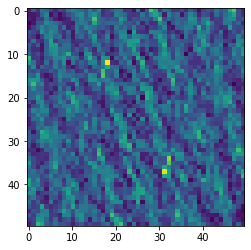

In [72]:
plt.imshow(ans_dft.reshape(50, 50)/500, vmin=0, vmax=20)

In [55]:
jnp.abs(get_params(opt_state)).max()

DeviceArray(18.00134, dtype=float32)

In [51]:
ans = jnp.abs(get_params(opt_state))

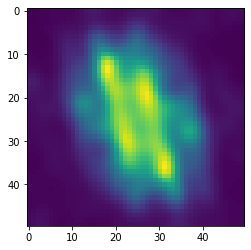

In [52]:
conv_ans = ndimage.gaussian_filter(onp.asarray(ans), 4./2.3)
plt.imshow(conv_ans)